In [1]:
import numpy as np
from sklearn.preprocessing import KernelCenterer
import os
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding
from numpy.linalg import multi_dot
from tqdm import tqdm_notebook
from collections import defaultdict
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.metrics import make_scorer, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, cross_validate
import shutil

import matplotlib.pyplot as plt
from utils import project

In [2]:
def NPR(X, Z, k=21):
    _, neigborhood_X = NearestNeighbors(n_neighbors=k).fit(X).kneighbors(X)
    _, neigborhood_Z = NearestNeighbors(n_neighbors=k).fit(Z).kneighbors(Z)
    n = X.shape[0]
    npr = 0
    for i in range(n):
        npr += np.intersect1d(neigborhood_X[i], neigborhood_Z[i]).shape[0]
    npr_normed = npr / (k * n)
    return npr_normed

In [3]:
# paths for the pivot tables
root = './separate_datasets_data'
paths = [os.path.join(root,path) for path in os.listdir(root)]
paths_pca = list(filter(lambda x: 'err' not in x.split("/")[-1].split(".")[0].split('_'), paths))

In [4]:
label2path_pca = {}
for path in paths_pca:
    label = path.split("/")[-1].split(".")[0]
    label_split = label.split('_')[:4]
    label = '_'.join(label_split)
    label2path_pca[label] = path

In [5]:
intrinsic_dims = np.load('./intrinsic_dims.npy',allow_pickle=True).item()

In [6]:
intrinsic_dims

{'./separate_datasets_data/ptb_proj_f.csv': array([5, 6, 7]),
 './separate_datasets_data/AGP_proj_o.csv': array([4, 5, 6]),
 './separate_datasets_data/t2d_proj_f.csv': array([4, 5, 6]),
 './separate_datasets_data/ibd_proj_o.csv': array([2, 3]),
 './separate_datasets_data/t2d_proj_g.csv': array([4, 5, 6]),
 './separate_datasets_data/ptb_proj_g.csv': array([5, 6, 7]),
 './separate_datasets_data/ptb_proj_o.csv': array([4, 5]),
 './separate_datasets_data/AGP_proj_f.csv': array([6, 7, 8, 9]),
 './separate_datasets_data/AGP_proj_g.csv': array([7, 8, 9]),
 './separate_datasets_data/ibd_proj_f.csv': array([3, 4]),
 './separate_datasets_data/t2d_proj_o.csv': array([2, 3, 4]),
 './separate_datasets_data/ibd_proj_g.csv': array([2, 3, 4, 5])}

In [7]:
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
    
        label = '_'.join([dataset_name, 'proj', tax_name])
        path = label2path_pca[label]

        d = np.genfromtxt(path, delimiter=';')
        print(d.shape)

(3457, 18)
(3457, 36)
(3457, 49)
(9511, 16)
(9511, 35)
(9511, 52)
(1044, 11)
(1044, 17)
(1044, 17)
(86, 6)
(86, 11)
(86, 12)



In [8]:
# calculate isomap projections for the different dimensions for O level and store to the csv files
mf_models = {'isomap':{'class':Isomap, 'params':{'n_neighbors':12}},
            'lle':{'class':LocallyLinearEmbedding, 'params':{'method':"modified",
                                                             'eigen_solver':'dense',
                                                             'n_neighbors':12}}}

def mae_score(y_pred, y):
    return np.linalg.norm(y_pred - y, axis=1, ord=1).mean() / np.linalg.norm(y, axis=1, ord=1).mean()

scorer_neg_mae = make_scorer(mae_score, greater_is_better=False)
# scorer_r2 = make_scorer(r2_score, greater_is_better=True)

results = defaultdict(dict)
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
    
        label = '_'.join([dataset_name, 'proj', tax_name])
        path = label2path_pca[label]

        d = np.genfromtxt(path, delimiter=';')
        assert not np.isnan(d).any()
        dims = intrinsic_dims[path]
        
        DIM_RANGE = np.arange(2, min(12,d.shape[1]))

        for mf_type, model in mf_models.items():
            metric_dict = defaultdict(list)
            metric_dict['range'] = DIM_RANGE
            # choose better dim
            for i in DIM_RANGE:
                model_class, model_params = model['class'], model['params']
                model_inst = model_class(n_components=i, **model_params)
                d_trans = model_inst.fit_transform(d)
                re = model_inst.reconstruction_error_ if hasattr(model_inst, 'reconstruction_error_') else model_inst.reconstruction_error()

                knn = KNeighborsRegressor(n_neighbors=i*2, weights='distance', n_jobs=-1)
                mo_knn = MultiOutputRegressor(knn)
                cv_results_neg_mae= cross_val_score(mo_knn, d_trans, d, scoring=scorer_neg_mae, cv=5, n_jobs=-1)
#                 cv_results_r2= cross_val_score(mo_knn, d_trans, d, scoring=scorer_r2, cv=10, n_jobs=-1)

                metric_dict['re'].append(re)
                metric_dict['knn_neg_mae'].append(-cv_results_neg_mae.mean())
#                 metric_dict['knn_r2'].append(cv_results_r2.mean())
                metric_dict['npr'].append(NPR(d, d_trans, k=5))
                metric_dict['dataset_transformed'].append(d_trans)

            results[label][mf_type] = metric_dict

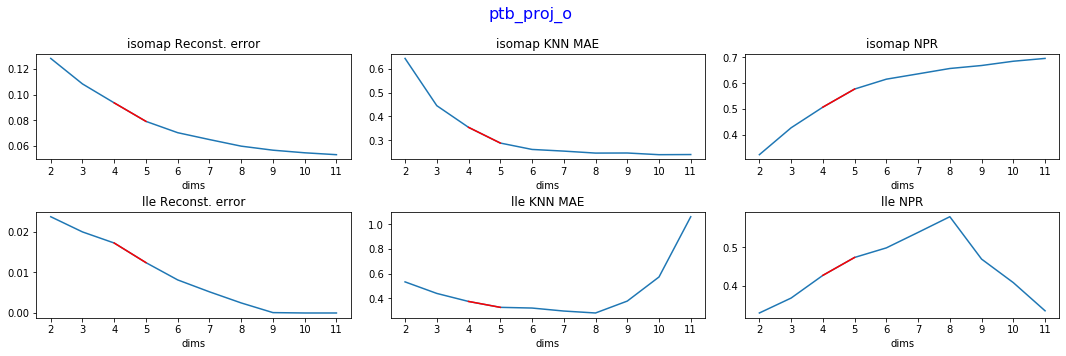

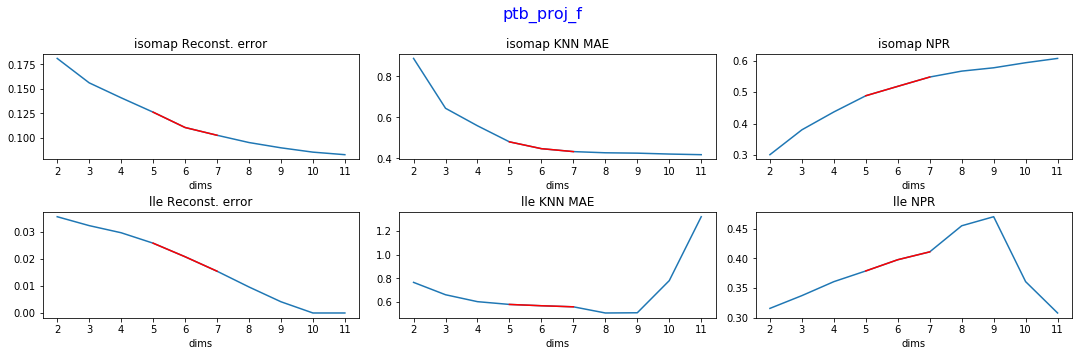

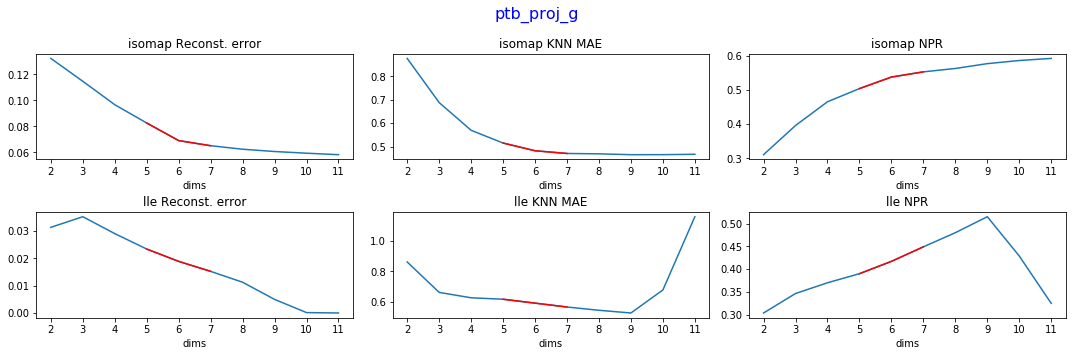

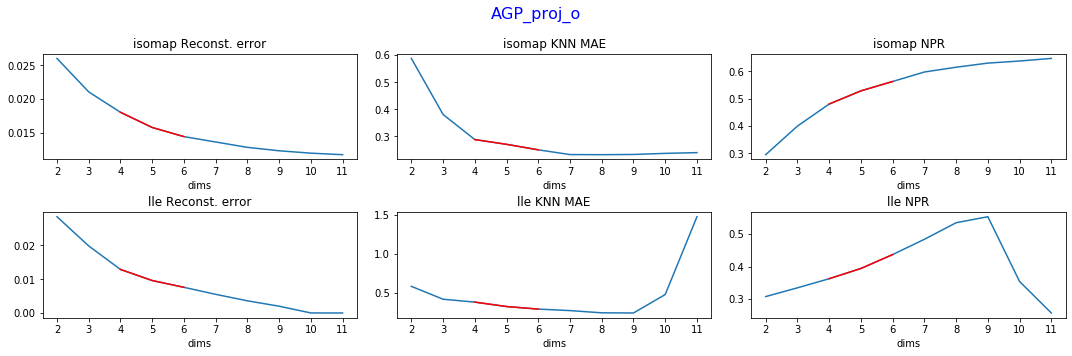

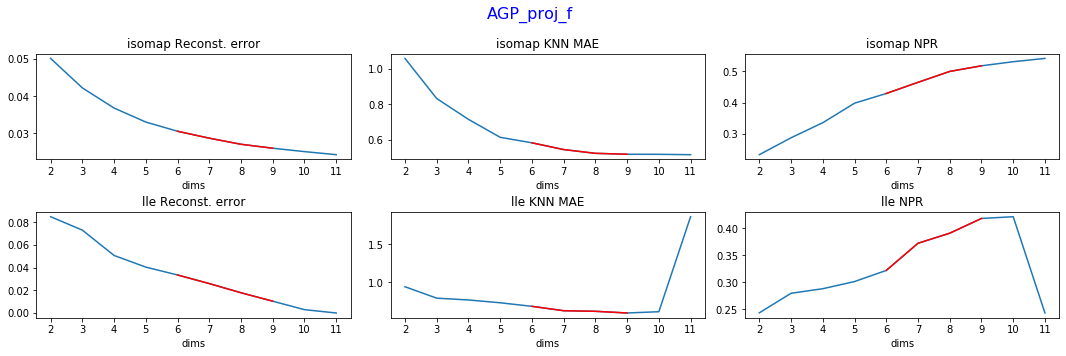

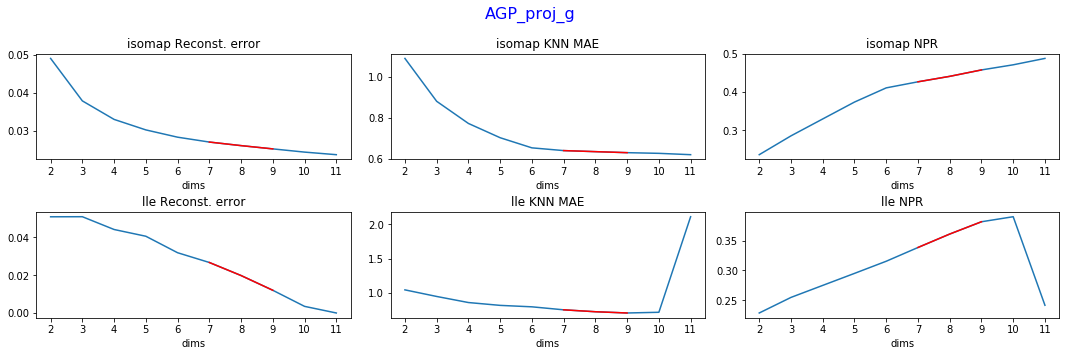

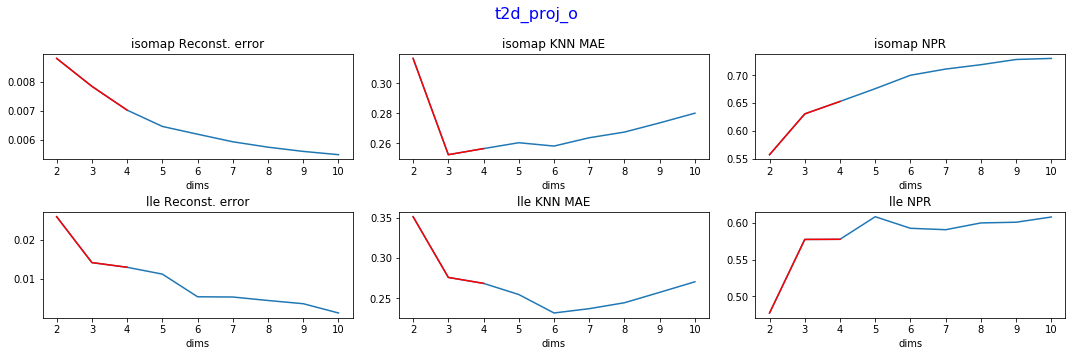

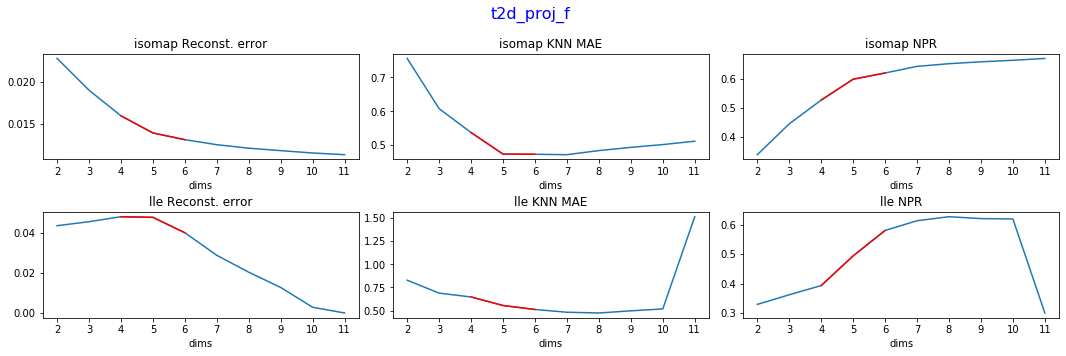

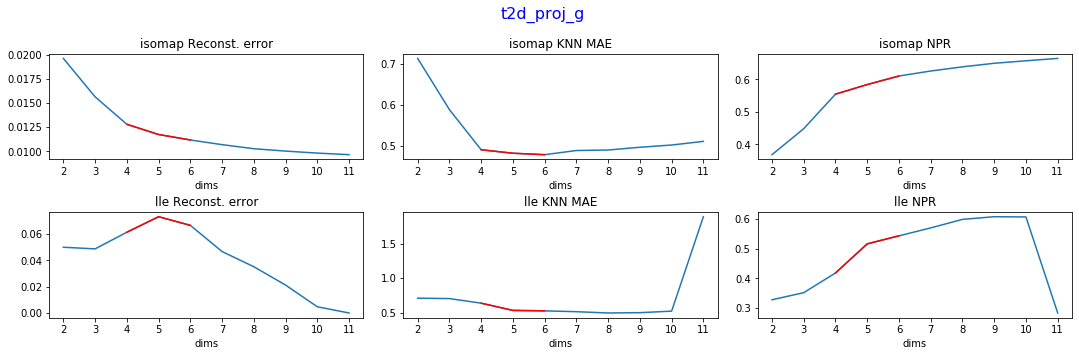

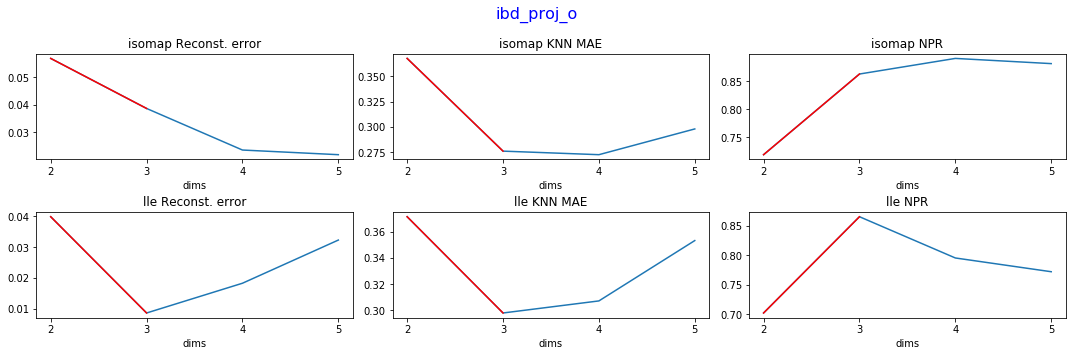

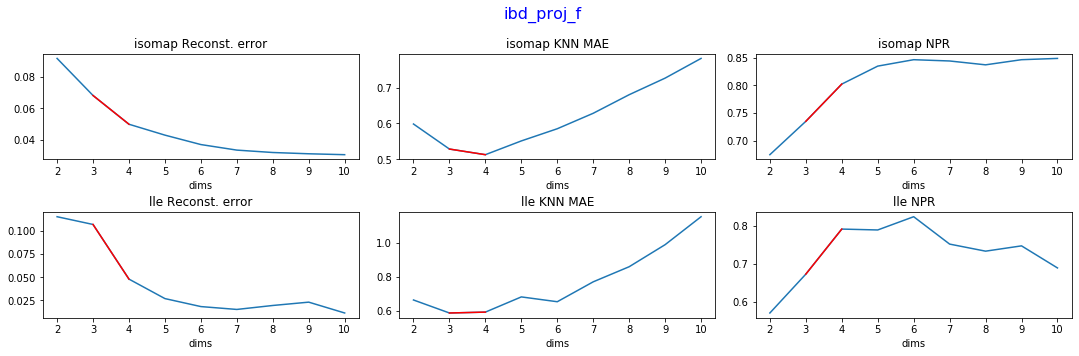

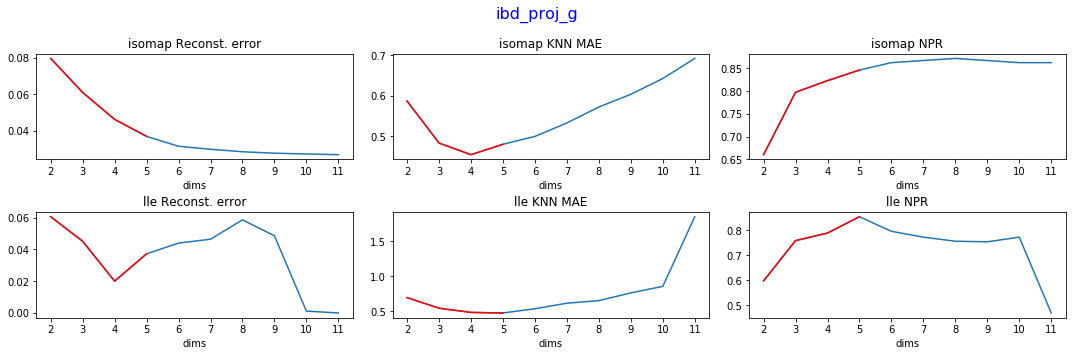

In [14]:
for dataset_name, mf_results_dict in results.items():
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,5))
    for i,(mf_method, metrics) in enumerate(mf_results_dict.items()):
        path = label2path_pca[dataset_name]
        recommended_intrinsic_dims = intrinsic_dims[path]
        
        re = np.array(metrics['re'])
        knn_mae = np.array(metrics['knn_neg_mae'])
#         knn_r2 = np.array(metrics['knn_r2'])
        npr = np.array(metrics['npr'])
        DIM_RANGE = np.array(metrics['range'])
        ind = np.intersect1d(DIM_RANGE, recommended_intrinsic_dims, assume_unique=True, return_indices=True)[1].tolist()
        
        axes[i,0].plot(DIM_RANGE, re)
        axes[i,0].set_title(mf_method + ' Reconst. error')
        axes[i,0].plot(recommended_intrinsic_dims, re[ind], 'r')
        axes[i,0].set_xticks(ticks=DIM_RANGE)
        axes[i,0].set_xticklabels(DIM_RANGE)
        axes[i,0].set_xlabel('dims')
        
        axes[i,1].plot(DIM_RANGE, knn_mae)
        axes[i,1].set_title(mf_method + ' KNN MAE')
        axes[i,1].plot(recommended_intrinsic_dims, knn_mae[ind], 'r')
        axes[i,1].set_xticks(ticks=DIM_RANGE)
        axes[i,1].set_xticklabels(DIM_RANGE)
        axes[i,1].set_xlabel('dims')
        
#         axes[i,2].plot(DIM_RANGE, knn_r2)
#         axes[i,2].set_title(mf_method + '_KNN R2')
#         axes[i,2].plot(recommended_intrinsic_dims, knn_r2[ind], 'r')
#         axes[i,2].set_xticks(ticks=DIM_RANGE)
#         axes[i,2].set_xticklabels(DIM_RANGE)
        
        axes[i,2].plot(DIM_RANGE, npr)
        axes[i,2].set_title(mf_method + ' NPR')
        axes[i,2].plot(recommended_intrinsic_dims, npr[ind], 'r')
        axes[i,2].set_xticks(ticks=DIM_RANGE)
        axes[i,2].set_xticklabels(DIM_RANGE)
        axes[i,2].set_xlabel('dims')
        
    fig.suptitle(dataset_name, fontsize=16, color='blue')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
plt.show()
        
        
        

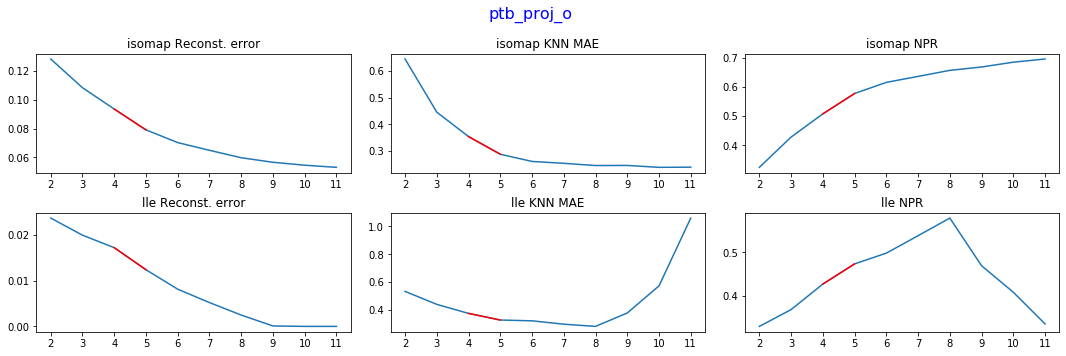

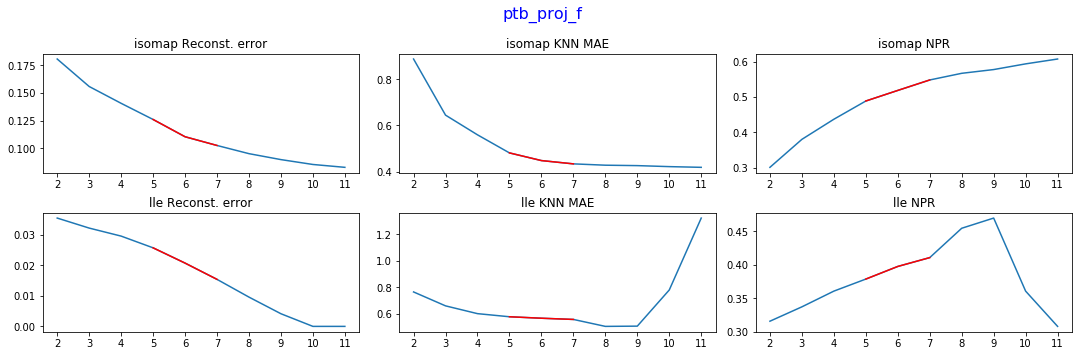

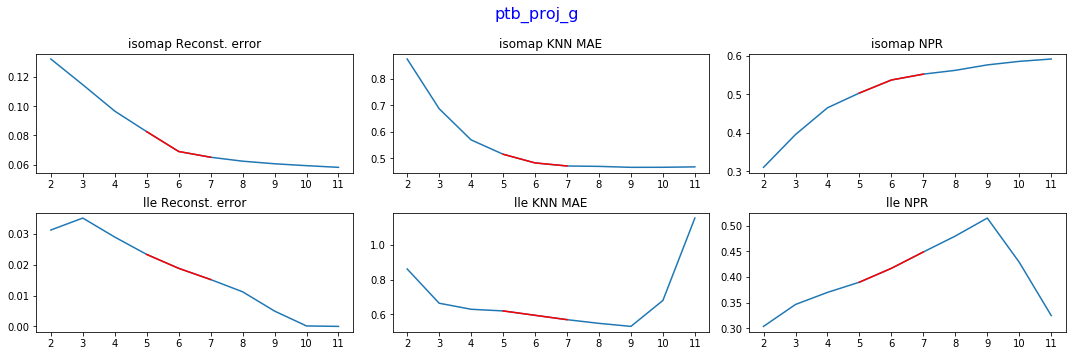

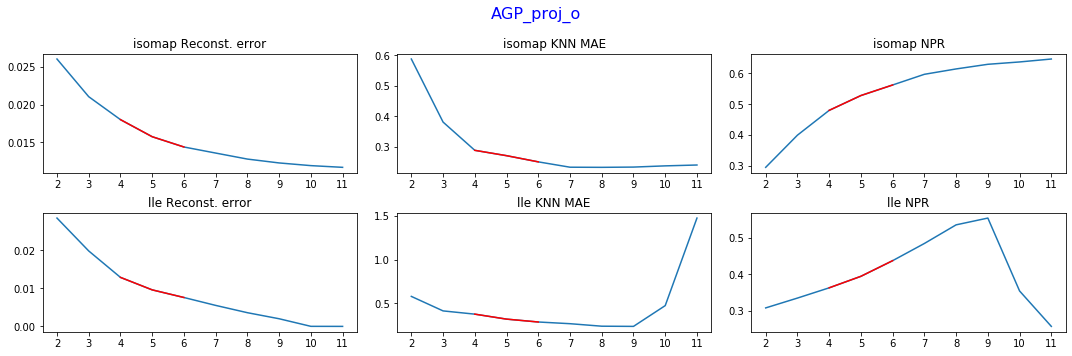

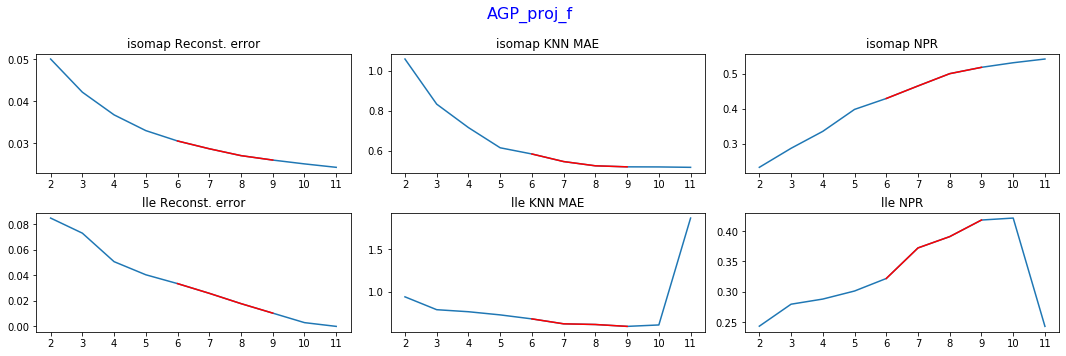

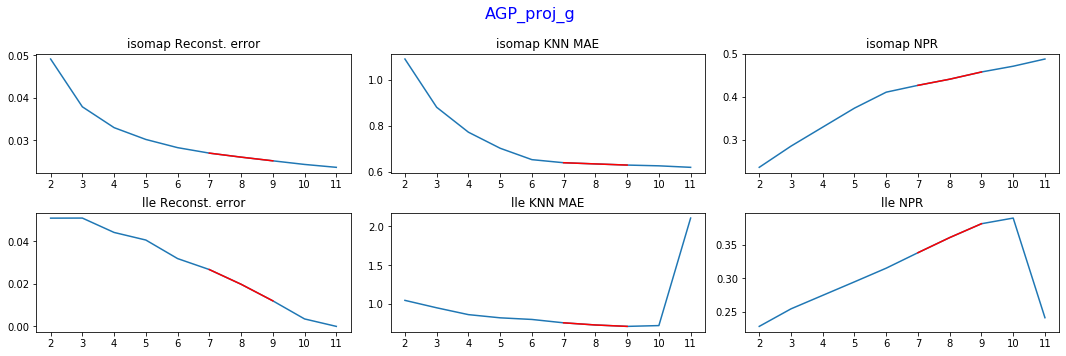

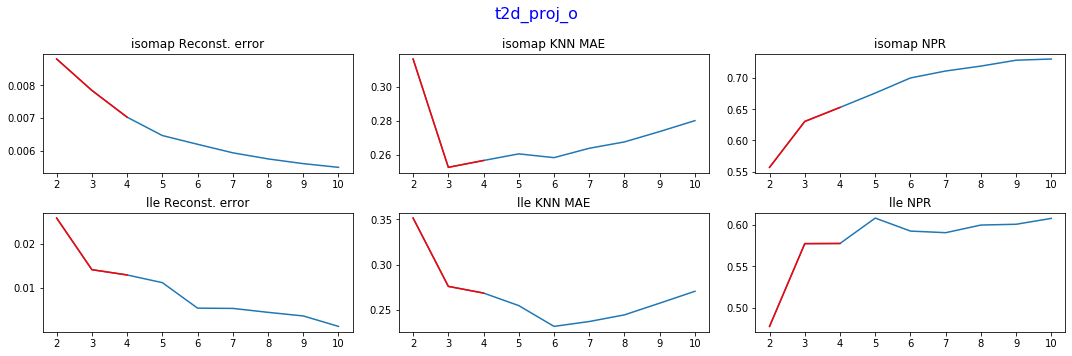

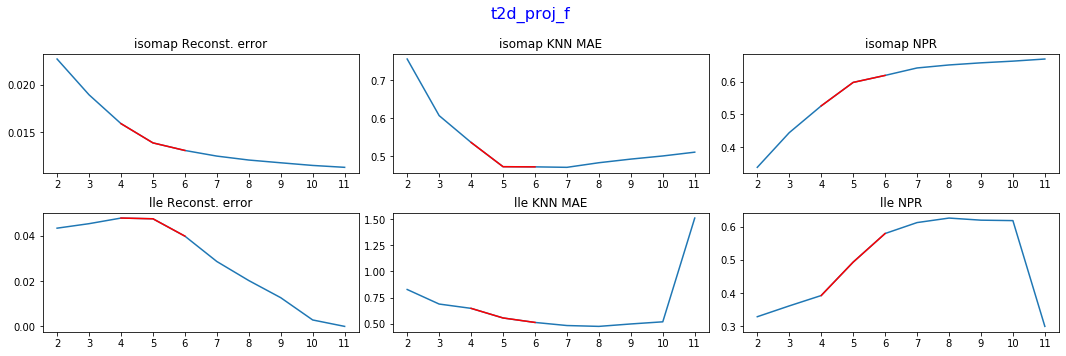

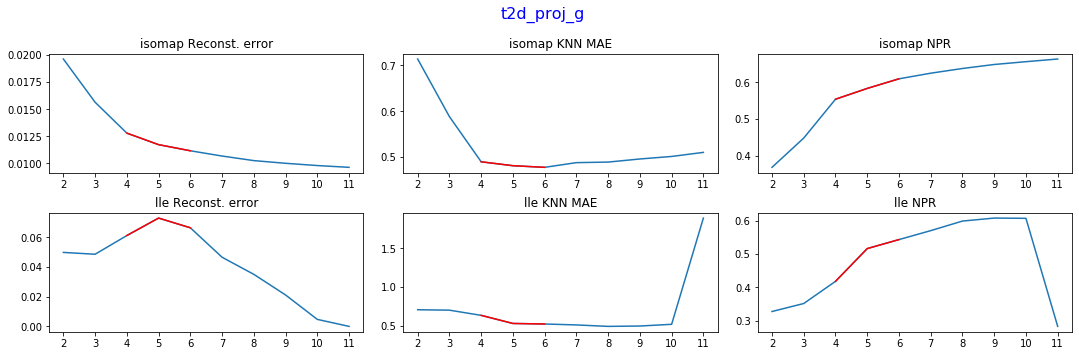

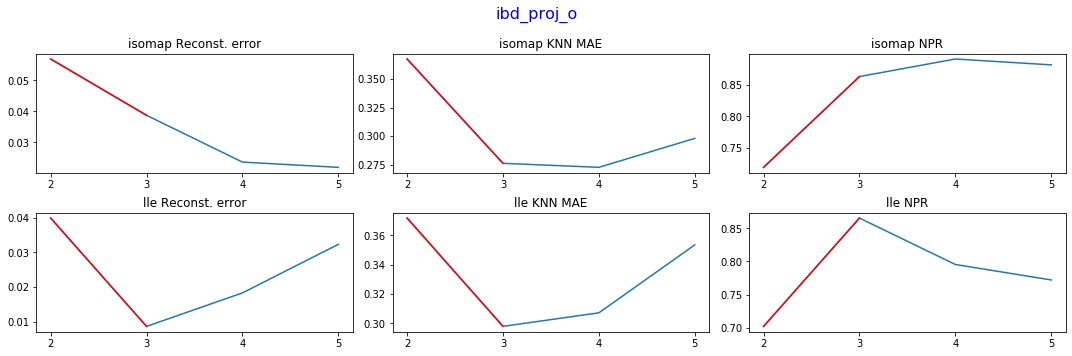

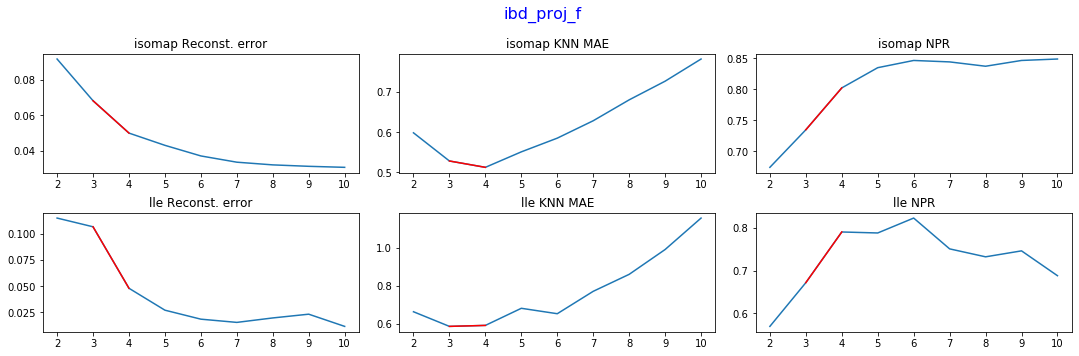

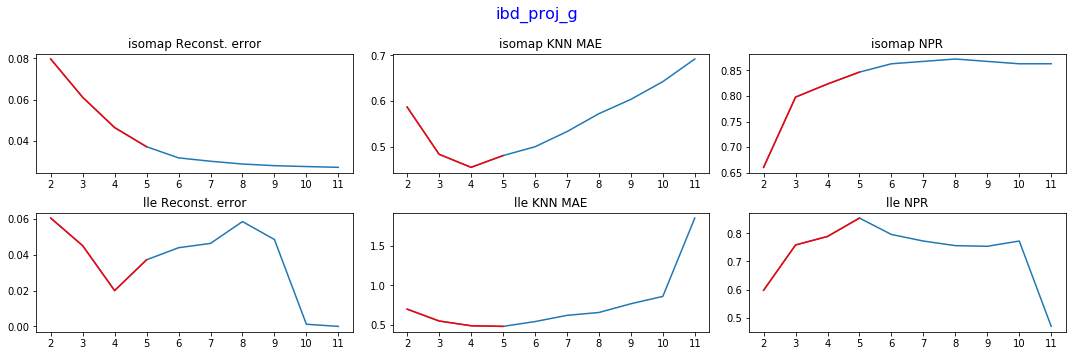

In [13]:
for dataset_name, mf_results_dict in results.items():
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,5))
    for i,(mf_method, metrics) in enumerate(mf_results_dict.items()):
        path = label2path_pca[dataset_name]
        recommended_intrinsic_dims = intrinsic_dims[path]
        
        re = np.array(metrics['re'])
        knn_mae = np.array(metrics['knn_neg_mae'])
#         knn_r2 = np.array(metrics['knn_r2'])
        npr = np.array(metrics['npr'])
        DIM_RANGE = np.array(metrics['range'])
        ind = np.intersect1d(DIM_RANGE, recommended_intrinsic_dims, assume_unique=True, return_indices=True)[1].tolist()
        
        axes[i,0].plot(DIM_RANGE, re)
        axes[i,0].set_title(mf_method + ' Reconst. error')
        axes[i,0].plot(recommended_intrinsic_dims, re[ind], 'r')
        axes[i,0].set_xticks(ticks=DIM_RANGE)
        axes[i,0].set_xticklabels(DIM_RANGE)
        
        axes[i,1].plot(DIM_RANGE, knn_mae)
        axes[i,1].set_title(mf_method + ' KNN MAE')
        axes[i,1].plot(recommended_intrinsic_dims, knn_mae[ind], 'r')
        axes[i,1].set_xticks(ticks=DIM_RANGE)
        axes[i,1].set_xticklabels(DIM_RANGE)
        
#         axes[i,2].plot(DIM_RANGE, knn_r2)
#         axes[i,2].set_title(mf_method + '_KNN R2')
#         axes[i,2].plot(recommended_intrinsic_dims, knn_r2[ind], 'r')
#         axes[i,2].set_xticks(ticks=DIM_RANGE)
#         axes[i,2].set_xticklabels(DIM_RANGE)
        
        axes[i,2].plot(DIM_RANGE, npr)
        axes[i,2].set_title(mf_method + ' NPR')
        axes[i,2].plot(recommended_intrinsic_dims, npr[ind], 'r')
        axes[i,2].set_xticks(ticks=DIM_RANGE)
        axes[i,2].set_xticklabels(DIM_RANGE)
        
    fig.suptitle(dataset_name, fontsize=16, color='blue')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
plt.show()
        
        
        

# Saving

In [39]:
# for label,label_dict in results.items(): 
#     for method_name, method_dict in label_dict.items(): 
#         recommended_intrinsic_dims = intrinsic_dims[label2path_pca[label]]
#         DIM_RANGE = np.array(metrics['range'])
#         ind = np.intersect1d(DIM_RANGE, recommended_intrinsic_dims, assume_unique=True, return_indices=True)[1].tolist()
#         print(label, method_name, ind[-1])
#         d_trans = method_dict['dataset_transformed'][ind[-1]]
#         name = f"./separate_datasets_transformed_data/{label}_{method_name}.csv"
#         np.savetxt(name, d_trans, delimiter=";")
